# Introducción a la Programación en JULIA
## Notebook 10

Mauricio Tejada

ILADES - Universidad Alberto Hurtado

Mayo 2019

## Contenidos

- [Ecuaciones No Lineales](#10.-Ecuaciones-No-Lineales)
    - [Métodos Numéricos y Ecuaciones No Lineales: Ideas Básicas](#10.1-Métodos-Numéricos-y-Ecuaciones-No-Lineales:-Ideas-Básicas)
    - [Las Funciones fzero y nlsolve](#10.2-Paquetes-Roots-y-NLsolve)

## 10. Ecuaciones No Lineales

*La exposición en esta sección sigue de cerca el capítulo 3 del libro de Miranda y Fackler.*

Los problemas que envuelven sistemas de ecuaciones no lineales son muy comunes en economía. Éstos se presentan en dos formatos:

- Búsqueda de raíces: $$f(x) = 0$$ con $f:R^n \rightarrow R^n$ y $x\in R^n$
- Punto fijo: $$x = g(x)$$ con $g:R^n \rightarrow R^n$ y $x\in R^n$ 

Ambas formas son equivalentes: 

- Problema de raíces expresado como un problema de punto fijo: $$g(x) = x - f(x)$$
- Problema de punto fijo expresado como un problema de raíces: $$f(x) = x-g(x)$$

En muchas aplicaciones económicas, no es posible encontrar una solución analítica a un problema no lineal y por tanto la solución tiene que hallarse de manera numérica.

Problemas:
- Los métodos numéricos con iterativos y son sensibles a la condición inicial.
- Los sistemas no lineales pueden tener más de una solución.

Vamos a analizar métodos que no usan derivadas (método de bisección y método de iteración de la función) y métodos de usan derivadas (Método de Newton y Método de quasi-Newton). 

Existen métodos más sofisticados basados en los métodos mencionados y sólo realizaremos una descripción escueta.

### 10.1 Métodos Numéricos y Ecuaciones No Lineales: Ideas Básicas

#### Método de Bisección

Es el método más simple y robusto para hallar la raíz de una función no lineal definida en $R$ en el intervalo $[a,b]$.

Buscamos resolver: $$f(x)=0$$ con $f:R \rightarrow R$.

Es un método iterativo que evalúa el signo en los puntos extremos y en el punto medio del intervalo y en función de ello reduce el intervalo de búsqueda. Repite este proceso hasta que el intervalos resultante sea menor que un nivel de tolerancia.

![](https://upload.wikimedia.org/wikipedia/commons/thumb/c/c2/Bisection_method.png/250px-Bisection_method.png)
<center>Fuente: Wikipedia.</center>

Requerimientos: La solución debe estar contenida en $[a,b]$ y la función debe ser continua en el intervalo. 

La siguiente función implementa el método de Bisección:

In [1]:
"""
**bisection** implementa el Método de Bisección

Uso: `root = bisect(f,a,b)`
"""
function bisect(f,a,b)

    if f(a)*f(b)>0 
        error("La función debe ser de signo distinto en los extremos")
    else
        tol = 1.5e-8;

        s = sign(f(a))
        x = (a+b)/2
        d = (b-a)/2

        while d>tol
            d = d/2
            if s == sign(f(x))
                x = x+d
            else
                x = x-d
            end
        end
        root = x
    end

return root
    
end

bisect

Para probar el método creamos la siguiente función $f(x) = x^3 -2$ (sabemos que la raíz es $2^{1/3}$):

In [2]:
function ff(x)
    return x^3-2
end

ff (generic function with 1 method)

Buscamos la raíz en el intervalos $[1,2]$.

In [3]:
x = bisect(ff,1,2)
print(x)

1.259921059012413

#### Iteración de la Función

El método de iteración de la función es un técnica iterativa usada para encontrar un punto fijo $x=g(x)$ con $g:R^n \rightarrow R^n$. Este método también puede ser aplicado al problema de búsqueda de raíces usando la transformación apropiada (ver más arriba).

La iteración se inicia con una conjetura inicia $x^(0)$ para el punto fijo y se la actualiza usando la siguiente regla: 

$$x^{(k+1)} \leftarrow g(x^{(k)})$$ 

Este proceso continúa iterando hasta que $g(x^{(k)})$ se "suficientemente" cercano a $x^{(k+1)}$.

La convergencia está garantizada si:

- $g$ es diferenciable.
- la conjetura inicial $x^{(0)}$ está suficientemente cerca del punto fijo $x^*$.
- $||g'(x^*)||<1$.

La siguiente figura ilustra la iteración de una función en $R$:

![](figs/fpi_miranda_fackler.png)
<center>Fuente: Miranda y Fackler (2002)</center>

La siguiente función implementa el método de iteración de la función:

In [4]:
using LinearAlgebra

In [5]:
"""
**fixpoint** implementa el Método de Iteración de la Función

Uso: `[x, gval] = fixpoint(f,x0)`
"""

function fixpoint(g,x0)
    
    tol     = 1.5e-8
    maxiter = 1000    

    x = x0
    iter = 0

    for i in 1:maxiter 
       iter = i
       gval = g(x)
       if norm(gval-x)<tol
           return x, gval
       end 
       x = gval;
    end

    if iter == maxiter
        println("No se obtuvo convergencia")
    end

end

fixpoint (generic function with 1 method)

Para probar el método creamos la siguiente función:

In [6]:
gg(x) = x^0.5

gg (generic function with 1 method)

Buscamos el punto fijo partiendo de una conjetura de $x=4$ (sabemos que el punto fijo es 1).

In [7]:
(xstar, gx) = fixpoint(gg,4)
println(xstar)
println(gx)

1.000000020657396
1.000000010328698


#### El Método de Newton

En la práctica muchos problemas se resuelven usando el método de Newton o variaciones de él. De hecho las funciones de Matlab para realizar ésta tarea usan justamente variaciones del método de Newton.

El método de Newton se basa en el principio de linelización sucesiva. Así, problemas no lineales son reemplazados por una secuencia de problemas lineales cuyas soluciones convergen a la solución del problema original. 

Este método puede ser aplicado tanto a problemas de búsqueda de raíz como problemas de punto fijo. En el último caso debe aplicarse la transformación apropiada (ver más arriba).

El método es iterativo y empieza con una conjetura inicial $x^{(0)}$ para la raíz del problema. La actualización desde $x^{(k)}$ a $x^{(k+1)}$ ocurre resolviendo un problema de búsqueda de raíces lineal. Aplicando la aproximación de Taylor de primer orden:

$$f(x) \approx f(x^{(k)}) + f'(x^{(k)})(x-x^{(k)}) = 0$$

Por tanto:

$$ x^{(k+1)} \leftarrow x^{(k)} - [f'(x^{(k)})]^{-1} f(x^{(k)})$$

La iteración concluye cuando $x^{(k)}$ se "suficientemente" cercano a $x^{(k+1)}$.

La convergencia está garantizada si:
- $f$ es continuamente derivable.
- La conjetura inicial $x^{(0)}$ está suficientemente cerca de la raíz $x^*$.
- $f'$ es invertible.

La siguiente figura ilustra la iteración de una función en $R$:

![](figs/newton_miranda_fackler.png)
<center>Fuente: Miranda y Fackler (2002)</center>

La siguiente función implementa el método de Newton:

In [8]:
"""
**newton** implementa el Método de Newton
    
Uso: `x = newton(f,x0)`
"""

function newton(f,x0; tol = 1.5e-8, maxiter = 1000)       

    x = x0
    iter = 0

    for i in 1:maxiter
        iter = i
        (fval, fjac) = f(x)
        x = x - fjac\fval
        if norm(fval) < tol
            break
        end
    end

    if iter == maxiter
        println("No se obtuvo convergencia")
    end

    return x
end

newton (generic function with 1 method)

Para probar el método usemos la función ya creada $f(x) = x^3 - 2$ y buscamos la raíz partiendo de la conjetura $x=1$. Note que la primera derivada es necesaria por lo que la función creada debe contener ambos la función matemática y su derivada como *outputs*.

In [9]:
function ff2(x)

    fval = x^3-2
    fjac = 3*x^2
    
    return fval, fjac

end

ff2 (generic function with 1 method)

In [10]:
x = newton(ff2,1)
println(x)

1.2599210498948732


#### El Método de Quasi-Newton

El problema del método de Newton es que requiere la matriz Jacobiana para realizar la linealización. En muchos problemas es difícil encontrar dicha matriz.

El Método de Quasi-Newton sigue la misma lógica que el método de Newton pero reemplaza la matriz Jacobiana por una aproximación fácil de computar. 

El costo viene asociado a que es más lento en converger y requiere de una aproximación inicial a la matriz Jacobiana. 

*Método de la Secante*

El *Método de la Secante* es el método de Quasi-Newton univariado más usado. La idea es reemplazar la derivada con una aproximación construida con los valores de la iteración anterior. La regla de actualización sería entonces:

$$ x^{(k+1)} \leftarrow x^{(k)} - \frac{x^{(k)}-x^{(k-1)}}{f(x^{(k)})-f(x^{(k-1)})} f(x^{(k)})$$

La siguiente función implementa el método de la secante:

In [11]:
"""
**secante** implementa el Método de la Secante

Uso: `x = secante(f,x0)`
"""

function secante(f,x0; tol = 1.5e-8, maxiter = 1000)
  
    x1 = 0.5*x0
    iter = 0    

    for i in 1:maxiter
        iter = i    
        fval0 = f(x0)
        fval1 = f(x1)
        x = x1 - ((x1-x0)/(fval1-fval0))*fval1
        if abs(fval1) < tol
            break
        end
        x0 = x1
        x1 = x
    end

    if iter == maxiter
        println("No se obtuvo convergencia")
    end

    return x
end

secante (generic function with 1 method)

Para probar el método usemos la función:

In [12]:
function ff(x)
    return x^3-2
end

ff (generic function with 1 method)

Buscamos la raíz conjeturando $x=1$.

In [13]:
xsol = secante(ff,1)
println(xsol)

1.2599210498948732


*Método de Broyden*

El *Método de Broyden* es el método de Quasi-Newton multivariado más usado. El método parte con una conjetura inicial para la raíz $x^{(0)}$ y para la matriz Jacobiana $A^{(0)}$. Las ecuaciones de actualización son para la raíz:

$$f(x) \approx f(x^{(k)}) + A^{(k)}(x-x^{(k)}) = 0$$

$$ x^{(k+1)} \leftarrow x^{(k)} - [A^{(k)}]^{-1} f(x^{(k)})$$

y para la matriz jacobiana:
    
$$f(x^{(k+1)}) - f(x^{(k)}) = A^{(k)}(x^{(k+1)} - x^{(k)})$$

$$A^{(k+1)} \leftarrow A^{(k)} + \left[f(x^{(k+1)}) - f(x^{(k)}) - A^{(k)}d^{(k)}\right] \frac{d^{(k)}`}{d^{(k)}` d^{(k)}}$$

con $d^{(k)} = x^{(k+1)}-x^{(k)}$.

En lugar de implomentar ese método (y otros) usaremos paquetes (más eficientes) escritos en Julia. 


### 10.2 Paquetes Roots y NLsolve

Julia cuenta dos paquetes diseñados para lidiar con problemas no lineales: (1) **Roots** y (2) **NLsolve**.

**Roots**

El paquete Roots contiene la función `fzero` para buscar la raíz de una función definida en los reales. Usa una combinación de métodos entre los cuales se encuentra los de bisección y el de la secante.

La sintaxis de esta función es:

`x = fzero(fun,x0,opciones)`

donde `fun` es una función definida en $R$ y `x0` es la conjetura inicial. 

- Si se provee un intervalo de búsqueda de la forma `fzero(fun,a,b)` Julia usara Bisección).
- Entre las opciones se puede usar por ejemplo `xatol=1e-7` para definir la tolerancia en la solución.
- También entre las opciones se puede definir el método, por ejemplo con `order=:secant` se define el uso del método de la secante.
- Si además de la función proveemos la derivada, de la forma `fzero(fun,dfun,x0)` Julia utilizará el método de Newton. 

El resultado es `x` la raíz.

In [14]:
using Roots
using Plots

┌ Info: Precompiling Roots [f2b01f46-fcfa-551c-844a-d8ac1e96c665]
└ @ Base loading.jl:1260


In [15]:
f(x) = exp(x) - x^4

f (generic function with 1 method)

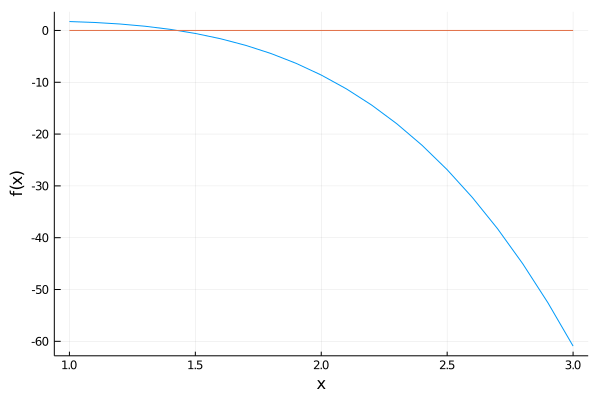

In [16]:
x = collect(1:0.1:3)
y = f.(x)
yz = zeros(length(x))
plot(x,[y, yz], ylabel = "f(x)", xlabel = "x", legend=:none)

Tenemos una raíz en el intervalo $[1,3]$.

In [17]:
xsol = fzero(f,1,3) # Usamos Bisección

1.4296118247255556

In [18]:
f(xsol)

0.0

¿Qué sucede si ampliamos el intervalo de búsqueda (por ejemplo al intervalo $[-10,10]$)?

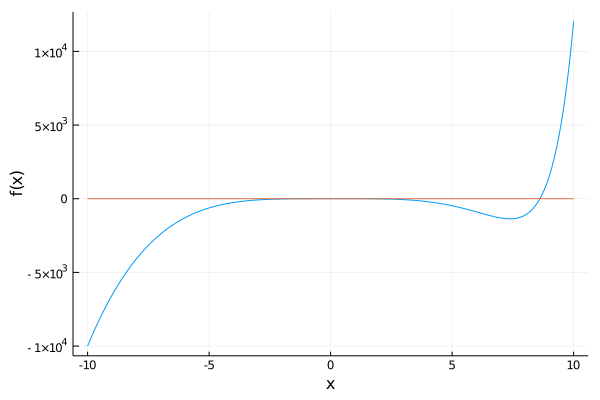

In [19]:
x = collect(-10:0.1:10)
y = f.(x)
yz = zeros(length(x))
plot(x,[y, yz], ylabel = "f(x)", xlabel = "x", legend=:none)

Tenemos más de una raíz! En el paquete Roots también tenemos la función `fzeros()` que es una extensión de la función anterior para buscar todas las posibles raíces:

In [20]:
xm = fzeros(f, -10, 10)

3-element Array{Float64,1}:
 -0.8155534188089606
  1.4296118247255556
  8.613169456441398

In [21]:
f.(xm)

3-element Array{Float64,1}:
  1.6653345369377348e-16
  0.0
 -2.7284841053187847e-12

**NLsolve**

El paquete **NLsolve** resuelve sistemas de ecuaciones no lineales. En particular, si $F(x)$ es una función multivariada, con $x\in R^n$, entonces la función nlsolve buscar el vector $x^*$ que satisface $F(x^*)=0$ (con algún nivel de tolerancia). Esta función usa variaciones (más robustas y eficientes) del método de Newton.

La sintaxis de esta función es:

`res = nlsolve(fun, x0, inplace = false, otras_opciones)`

donde `fun` es un vector de `n` función definidas en $R^n$ y $x0 \in R^n$ es la conjetura inicial. La opción `inplace`  se usa cuando se define el problema como uno de búsqueda de raíces.

Resolvamos el siguiente sistema de ecuaciones no lineales usando `nlsolve`.

$$e^{-e^{-(x+y)}} = y(1+x^2)$$
$$x \cos y + y \sin x = \frac{1}{2}$$

La conjetura inicial será $x=y=0.5$.

In [22]:
using NLsolve

┌ Info: Precompiling NLsolve [2774e3e8-f4cf-5e23-947b-6d7e65073b56]
└ @ Base loading.jl:1260


In [23]:
function sistemanl(x)

    f = zeros(length(x))

    f[1] = exp(-exp(-x[1]+x[2])) - x[2]*(1+x[1]^2)
    f[2] = x[1]*cos(x[2]) + x[2]*sin(x[1]) - 0.5
    
    return f

end

sistemanl (generic function with 1 method)

In [24]:
xss = nlsolve(sistemanl, [0.5, 0.5], inplace = false)

Results of Nonlinear Solver Algorithm
 * Algorithm: Trust-region with dogleg and autoscaling
 * Starting Point: [0.5, 0.5]
 * Zero: [0.3931134000423612, 0.33662701554572494]
 * Inf-norm of residuals: 0.000000
 * Iterations: 3
 * Convergence: true
   * |x - x'| < 0.0e+00: false
   * |f(x)| < 1.0e-08: true
 * Function Calls (f): 4
 * Jacobian Calls (df/dx): 4

In [25]:
xss.zero # Vector con el resultado

2-element Array{Float64,1}:
 0.3931134000423612
 0.33662701554572494

La matriz Jacobiana no fue provista y por tanto para utilizar métodos tipo Quasi-Newton Julia tuvo que aproximarla (usando diferencias finitas). Proveer está matriz (cuando es posible) asegura mayor precisión. La sintaxis es:

`res = nlsolve(fun, jacobiana, x0, inplace = false, otras_opciones)`

Resolvamos el sistema (ejemplo tomado de la documentación de nlsolve):

$$(x+3)(y^3-7) = -18$$
$$\sin(y\exp(x)-1) = 0$$

In [26]:
function sistema2(x)

    f = zeros(length(x))

    f[1] = (x[1]+3)*(x[2]^3-7)+18
    f[2] = sin(x[2]*exp(x[1])-1)
    
    return f
end

sistema2 (generic function with 1 method)

In [27]:
xss = nlsolve(sistema2, [0.1, 1.2], inplace = false);

In [28]:
xss.zero

2-element Array{Float64,1}:
 -7.775548712324193e-17
  0.9999999999999999

Ahora definamos una función con la matriz jacobiana:

In [29]:
function jacob_sistema2(x)
    
    J = zeros(2,2)

    J[1, 1] = x[2]^3-7
    J[1, 2] = 3*x[2]^2*(x[1]+3)
    u = exp(x[1])*cos(x[2]*exp(x[1])-1)
    J[2, 1] = x[2]*u
    J[2, 2] = u
    
    return J
end

jacob_sistema2 (generic function with 1 method)

In [30]:
xss = nlsolve(sistema2, jacob_sistema2, [0.1, 1.2], inplace = false);

In [31]:
xss.zero

2-element Array{Float64,1}:
 -3.7818049096324184e-16
  1.0000000000000002

Otras opciones de la función nlsolve son:

- `xtol`: Tolerancia para la solución (por defecto 0.0)
- `ftol`: Tolerancia para la solución (por defecto 1e-8).
- `iterations`: Máximo número de iteraciones (por defecto 1000).
- `show_trace`: muestra en pantalla las iteraciones del algoritmo (por defecto false).